In [1]:
#please run roscore on terminal


In [2]:
#please run gazebo world on terminal


In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import itertools
import seaborn as sb
import numpy as np
import argparse
import logging
import os
import pickle
from datetime import datetime
import gc
gc.enable()
import rospy
import roslib
import rospy
import rostopic
import random
import time
import math
import csv
from std_srvs.srv import Empty
from gazebo_msgs.srv import SetModelConfiguration
from control_msgs.msg import JointControllerState
from sensor_msgs.msg import JointState
from gazebo_msgs.msg import LinkStates
from gazebo_msgs.msg import ContactsState
from geometry_msgs.msg import Pose
from std_msgs.msg import Float64
from std_msgs.msg import String
from sensor_msgs.msg import Joy
from gazebo_msgs.srv import DeleteModel
from gazebo_msgs.srv import SpawnModel
from controller_manager_msgs.srv import LoadController
from controller_manager_msgs.srv import SwitchController

import threading
from scipy.interpolate import interp1d

LOG_SIG_MAX = 2
LOG_SIG_MIN = -20
epsilon = 1e-6
tf.keras.backend.set_floatx('float64')

gpu_available = tf.test.is_gpu_available()
sb.set()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-02-05 10:04:36.493210: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-05 10:04:37.677124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-05 10:04:37.682583: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-05 10:04:37.682851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [4]:
ENV_NAME = 'BipedalWalker-UTHAI'

In [5]:
LAP = rospy.Publisher(
        'uthai/l_ankle_pitch_position/command', Float64, queue_size=10)
LAR = rospy.Publisher(
    'uthai/l_ankle_roll_position/command', Float64, queue_size=10)
LHP = rospy.Publisher(
    'uthai/l_hip_pitch_position/command', Float64, queue_size=10)
LHR = rospy.Publisher('uthai/l_hip_roll_position/command',
                     Float64, queue_size=10)
#LHY = rospy.Publisher('uthai/l_hip_yaw_position/command',
#                      Float64, queue_size=10)
LKP = rospy.Publisher(
    'uthai/l_knee_pitch_position/command', Float64, queue_size=10)
RAP = rospy.Publisher(
    'uthai/r_ankle_pitch_position/command', Float64, queue_size=10)
RAR = rospy.Publisher(
    'uthai/r_ankle_roll_position/command', Float64, queue_size=10)
RHP = rospy.Publisher(
    'uthai/r_hip_pitch_position/command', Float64, queue_size=10)
RHR = rospy.Publisher('uthai/r_hip_roll_position/command',
                      Float64, queue_size=10)
#RHY = rospy.Publisher('uthai/r_hip_yaw_position/command',
#                      Float64, queue_size=10)
RKP = rospy.Publisher(
    'uthai/r_knee_pitch_position/command', Float64, queue_size=10)

reset_simulation = rospy.ServiceProxy('/gazebo/reset_world', Empty)

reset_joints = rospy.ServiceProxy('/gazebo/set_model_configuration', SetModelConfiguration)

unpause = rospy.ServiceProxy('/gazebo/unpause_physics', Empty)

pause = rospy.ServiceProxy('/gazebo/pause_physics', Empty)

In [6]:
fall = 0
rospy.init_node("q_set_control_node")
rate = rospy.Rate(50)


In [7]:
class RobotState(object):
    def __init__(self):

        self.outer_ring_inner_ring_theta = 0.0
        self.mean = 0
        self.last_mean =0
        self.r_ankle =0.0
        
        self.l_ankle = 0.0
        
        self.waist_z = 0.0

        
        self.LAP_theta = 0.0
        self.LAP_theta_dot = 0.0
        
        self.LAR_theta = 0.0
        self.LAR_theta_dot = 0.0
        
        self.LHP_theta = 0.0
        self.LHP_theta_dot = 0.0
        
        self.LHR_theta = 0.0
        self.LHR_theta_dot = 0.0
        #self.LHY_theta = 0.0
        #self.LHY_theta_dot = 0.0
        
        self.LKP_theta = 0.0
        self.LKP_theta_dot = 0.0
        
        self.RAP_theta = 0.0
        self.RAP_theta_dot = 0.0
        
        self.RAR_theta = 0.0
        self.RAR_theta_dot = 0.0
        
        self.RHP_theta = 0.0
        self.RHP_theta_dot = 0.0
        
        self.RHR_theta = 0.0
        self.RHR_theta_dot = 0.0
        
        #self.RHY_theta = 0.0
        #self.RHY_theta_dot = 0.0
        
        self.RKP_theta = 0.0
        self.RKP_theta_dot = 0.0
        
 
        #self.footr_contact = 0
        #self.footl_contact = 0
        #                                                      LAR
        #                                 LHR
        #RAR
        #RHR
        
        self.robot_state = [self.LAP_theta, self.LAP_theta_dot,self.LAR_theta,self.LAR_theta_dot,\
        self.LHP_theta, self.LHP_theta_dot,self.LHR_theta,self.LHR_theta_dot,\
        self.LKP_theta,self.LKP_theta_dot,self.RAP_theta,self.RAP_theta_dot,\
        self.RHP_theta,self.RHP_theta_dot,self.RHR_theta,self.RHR_theta_dot,\
        self.RKP_theta,self.RKP_theta_dot,self.r_ankle , self.l_ankle,self.waist_z]
        
        """
        
        self.robot_state_vel = [self.LAP_theta_dot, \
        self.LHP_theta_dot, \
        self.LKP_theta_dot,self.RAP_theta_dot,\
        self.RHP_theta_dot,\
        self.RKP_theta_dot]
        
        """

        self.latest_reward = 0.0
        self.best_reward = -100000000000000.0
        self.episode = 0
        self.last_outer_ring_inner_ring_theta = 0.0
        self.last_time = 0.0

        self.fall = 0
        self.done = False
        self.count_of_1 = 0
        self.avg_reward = 0.0


In [8]:
class Publisher(threading.Thread):
    def __init__(self,LAP,LAR ,LHP,LHR,LKP,RAP,RAR,RHP,RHR,RKP, rate):
        threading.Thread.__init__(self)
        self.counter = 0
        self.LAP = LAP
        self.LAR = LAR
        self.LHP = LHP
        self.LHR = LHR
        #self.LHY = LHY
        self.LKP = LKP
        self.RAP = RAP
        self.RAR = RAR
        self.RHP = RHP
        self.RHR = RHR
        #self.RHY = RHY
        self.RKP = RKP
        
        self.rate = rate


    def run(self):
        publisher(self.LAP,self.LAR,self.LHP,self.LHR,self.LKP,self.RAP,self.RAR,self.RHP,\
        self.RHR,self.RKP,self.rate, self.counter)

In [9]:
robot_state = RobotState()


In [10]:
def set_robot_state():
    robot_state.robot_state =  [robot_state.LAP_theta, robot_state.LAP_theta_dot,robot_state.LAR_theta,robot_state.LAR_theta_dot,\
        robot_state.LHP_theta, robot_state.LHP_theta_dot,robot_state.LHR_theta,robot_state.LHR_theta_dot,\
        robot_state.LKP_theta,robot_state.LKP_theta_dot,robot_state.RAP_theta,robot_state.RAP_theta_dot,\
        robot_state.RHP_theta,robot_state.RHP_theta_dot,robot_state.RHR_theta,robot_state.RHR_theta_dot,\
        robot_state.RKP_theta,robot_state.RKP_theta_dot,robot_state.r_ankle ,robot_state.l_ankle, robot_state.waist_z]
    """
    robot_state.robot_state_vel= [robot_state.LAP_theta_dot, \
        robot_state.LHP_theta_dot, \
        robot_state.LKP_theta_dot,robot_state.RAP_theta_dot,\
        robot_state.RHP_theta_dot,\
        robot_state.RKP_theta_dot]
    """


In [11]:
def reset_joint_hassan():
    #LHY.publish(0)
    #RHY.publish(0)
    LAR.publish(0)
    LHR.publish(0)
    RAR.publish(0)
    RHR.publish(0)

    LHP.publish(0)
    LKP.publish(0)
    LAP.publish(0)
    RHP.publish(0)
    RKP.publish(0)
    RAP.publish(0)


In [12]:
def Reset() :
     for _ in range(2):
            reset()
            
     try:
        pause()
     except (rospy.ServiceException) as e:
        print ("rospause failed!'")

In [13]:
def reset():
    # ['waist_thighR', 'waist_thighL', 'thighR_shankR', 'thighL_shankL', 'outer_ring_inner_ring', 'inner_ring_boom', 'boom_waist']

    rospy.wait_for_service('gazebo/set_model_configuration')
    
    try:
        reset_joint_hassan()
        #delay_error()
        robot_state.last_outer_ring_inner_ring_theta = 0.0
        
        
    except (rospy.ServiceException) as e:
        print ("reset_joints failed!")
    
    rospy.wait_for_service('/gazebo/pause_physics')

    
    rospy.wait_for_service('gazebo/reset_world')
    try:
        reset_simulation()
        
    except(rospy.ServiceException) as e :
        print ("reset_world failed!")
        
    #time.sleep(1)
    """
    try:
        pause()
        print("-------------paused_simulation-----------")
    except (rospy.ServiceException) as e:
        print ("rospause failed!'")
    """
    set_robot_state()
    

In [14]:
def best_reset():        
        rospy.wait_for_service('/gazebo/delete_model')
        try:
                DeleteModel()

        except (rospy.ServiceException) as e:
                print ("delete model  failed!")
        rospy.wait_for_service('/gazebo/spawn_urdf_model')
        try:
                SpawnModel()

        except (rospy.ServiceException) as e:

               print ("spawn_urdf_model failed!")
        try:
           pause()
        except (rospy.ServiceException) as e:
           print ("pause failed!'")
        rospy.wait_for_service('gazebo/set_model_configuration')

        try:
                reset_joint_hassan()
                robot_state.last_outer_ring_inner_ring_theta = 0.0
                robot_state.last_mean = 0.0
        except (rospy.ServiceException) as e:
                print ("reset_joints failed!")
        
        
        try:
           unpause()
        except (rospy.ServiceException) as e:
           print ("unpause failed!'")
        
        rospy.wait_for_service("/uthai/controller_manager/load_controller")
        
        error_compensator()
        time.sleep(0.1)

        try:
           LoadController()
        except (rospy.ServiceException) as e:
           print ("LoadController failed!'")
        rospy.wait_for_service("/uthai/controller_manager/switch_controller")
        try:
           SwitchController()
        except (rospy.ServiceException) as e:
           print ("SwitchController failed!")
        rospy.wait_for_service('gazebo/reset_world')
        try:
            reset_simulation()
        
        except(rospy.ServiceException) as e :
            print ("reset_world failed!")
        reset_joint_hassan()
        while True :
             if robot_state.waist_z > 0.55 and robot_state.waist_z < 0.9 :
                    break
        #error_compensator()
        #time.sleep(1)
        rospy.wait_for_service('/gazebo/pause_physics')
        try:
           pause()
        except (rospy.ServiceException) as e:
           print ("rospause failed!'")
        set_robot_state()

In [15]:
def reset():
    # ['waist_thighR', 'waist_thighL', 'thighR_shankR', 'thighL_shankL', 'outer_ring_inner_ring', 'inner_ring_boom', 'boom_waist']
    rospy.wait_for_service('gazebo/reset_world')
    try:
        reset_simulation()
    except(rospy.ServiceException) as e:
        print ("reset_world failed!")


    rospy.wait_for_service('gazebo/set_model_configuration')

    try:
        reset_joints("uthai", "robot_description", ["l_ankle_pitch_joint","l_ankle_roll_joint","l_hip_pitch_joint","l_knee_pitch_joint","l_hip_roll_joint","r_ankle_pitch_joint" ,"r_ankle_roll_joint","r_hip_pitch_joint","r_hip_roll_joint","r_knee_pitch_joint"], 
                     [0.0,0.0,0.0, 0.0, 0.0, 0.0,0.0,0.0,0.0,0.0])
        #reset_joint_hassan()
        #error_compensator()
        robot_state.last_outer_ring_inner_ring_theta = 0.0
    except (rospy.ServiceException) as e:
        print ("reset_joints failed!")

    rospy.wait_for_service('/gazebo/pause_physics')
    try:
        pause()
    except (rospy.ServiceException) as e:
        print ("rospause failed!")

    set_robot_state()

    # print "called reset()"

In [16]:
def error_compensator() :
    
    st= time.time()
    global break_loop
    while True : 
         a = tf.constant([robot_state.LAP_theta ,robot_state.LHR_theta,robot_state.LHP_theta ,
robot_state.LKP_theta,robot_state.RAR_theta, robot_state.RAP_theta,
robot_state.RHP_theta ,robot_state.RKP_theta ,robot_state.LAR_theta,robot_state.RHR_theta])
         b = tf.constant([robot_state.LAP_theta_dot ,robot_state.LHR_theta_dot,robot_state.LHP_theta_dot ,
robot_state.LKP_theta_dot,robot_state.RAR_theta_dot, robot_state.RAP_theta_dot,
robot_state.RHP_theta_dot ,robot_state.RKP_theta_dot ,robot_state.LAR_theta_dot,robot_state.RHR_theta_dot])
         error_norm_b = tf.norm(b,ord=2)#norm1
         error_norm_a = tf.norm(a,ord=2)#norm1
         #print(tf.norm(b,ord=2))
         if error_norm_a < 0.1 or abs(robot_state.outer_ring_inner_ring_theta)>9:
                break
         if abs(st-time.time()) > 6 :
                break_loop = True
                print("-----------tool_keshid_oomadam_biroon--------")
                #break
                while True :
                    a=1
                    pass
                


In [17]:
def take_action(action):
    rospy.wait_for_service('/gazebo/unpause_physics')

    try:
        unpause()
    except (rospy.ServiceException) as e:
        print ("/gazebo/pause_physics service call failed")
    last_time = time.time()
    LAP.publish(action[0])
    LAR.publish(action[1])
    LHP.publish(action[2])
    LHR.publish(action[3])
    #LHY.publish(action[2])
    LKP.publish(action[4])
    RAP.publish(action[5])
    RAR.publish(action[6])
    RHP.publish(action[7])
    RHR.publish(action[8])
    #RHY.publish(action[6])
    RKP.publish(action[9])


    reward = -0.1  # when it used to run, used to be -0.1
    #reward = 1
    #sky= (robot_state.r_ankle < 0.2 or  robot_state.l_ankle <0.2)
    #print(robot_state.waist_z)
    #print("time : " ,current_time- last_time)
    
    if robot_state.waist_z > 0.5 and robot_state.waist_z < 0.9  :#0.36
            
            #print("ekhtelaf:",robot_state.outer_ring_inner_ring_theta - robot_state.last_outer_ring_inner_ring_theta)
            #print(robot_state.mean - robot_state.last_mean)
            if  (robot_state.outer_ring_inner_ring_theta - robot_state.last_outer_ring_inner_ring_theta) >= 0.0: #-0.001forward motion
                         #if (robot_state.mean - robot_state.last_mean)>0.01 :
            
                         #print("delta-time :" , delta_time)
                         #dt= time.time() - last_time
            
                         reward += ((robot_state.outer_ring_inner_ring_theta - robot_state.last_outer_ring_inner_ring_theta)*100)
                         #print("reward" ,(robot_state.outer_ring_inner_ring_theta - robot_state.last_outer_ring_inner_ring_theta)/dt)
                         #reward += ((robot_state.mean - robot_state.last_mean)*100)
            
    
    else :
        reward += -100
        #print("i am in if 1")
        robot_state.done = True
        robot_state.fall = 0
        
    #robot_state.last_time = current_time
    robot_state.last_outer_ring_inner_ring_theta = robot_state.outer_ring_inner_ring_theta
    #robot_state.last_mean = robot_state.mean
    
    if robot_state.outer_ring_inner_ring_theta > 6.0:
        reward += 100
        #print('i am in if 2')
        robot_state.done = True
        robot_state.fall = 1
        #break_loop = True
        print("-----------tool_keshid_oomadam_biroon--------")
        print ("REACHED TO THE END!")
    
    
    
    #"outer_ring_inner_ring_theta :",robot_state.outer_ring_inner_ring_theta,
    #      "last_outer_ring_inner_ring_theta:",robot_state.last_outer_ring_inner_ring_theta,
    #     "ekhtelaf :",robot_state.outer_ring_inner_ring_theta - robot_state.last_outer_ring_inner_ring_theta)
    rate.sleep()
    return reward, robot_state.done

In [18]:
def callbackJointStates(data):

    robot_state.data = data
    

    if len(data.velocity)!=0:
        
        robot_state.LAP_theta_dot = np.clip(data.velocity[0],-10,10)
        
        robot_state.LAR_theta_dot = np.clip(data.velocity[1],-10,10)
        
        robot_state.LHP_theta_dot = np.clip(data.velocity[2],-10,10)
        
        robot_state.LHR_theta_dot = np.clip(data.velocity[3],-10,10)
        
        #robot_state.LHY_theta_dot = data.velocity[2]
        
        robot_state.LKP_theta_dot = np.clip(data.velocity[4],-10,10)
        
        robot_state.RAP_theta_dot = np.clip(data.velocity[5],-10,10)
        
        robot_state.RAR_theta_dot = np.clip(data.velocity[6],-10,10)
        
        robot_state.RHP_theta_dot = np.clip(data.velocity[7],-10,10)
        
        robot_state.RHR_theta_dot = np.clip(data.velocity[8],-10,10)
        
        #robot_state.RHY_theta_dot = data.velocity[6]
        
        robot_state.RKP_theta_dot = np.clip(data.velocity[9],-10,10)
    


        robot_state.LAP_theta = data.position[0]
        robot_state.LAR_theta = data.position[1]
        robot_state.LHP_theta = data.position[2]
        robot_state.LHR_theta = data.position[3]
        #robot_state.LHY_theta = data.position[2]
        robot_state.LKP_theta = data.position[4]
        robot_state.RAP_theta = data.position[5]
        robot_state.RAR_theta = data.position[6]
        robot_state.RHP_theta = data.position[7]
        robot_state.RHR_theta = data.position[8]
        #robot_state.RHY_theta = data.position[6]
        robot_state.RKP_theta = data.position[9]

        

    else:
        robot_state.LAP_theta_dot = 0
        
        robot_state.LAR_theta_dot = 0
        
        robot_state.LHP_theta_dot = 0
        
        robot_state.LHR_theta_dot = 0
        
        #robot_state.LHY_theta_dot = 0
        
        robot_state.LKP_theta_dot = 0
        
        robot_state.RAP_theta_dot = 0
        
        robot_state.RAR_theta_dot = 0
        
        robot_state.RHP_theta_dot = 0
        
        robot_state.RHR_theta_dot = 0
        
        #robot_state.RHY_theta_dot = 0
        
        robot_state.RKP_theta_dot = 0

        robot_state.LAP_theta = 0
        robot_state.LAR_theta = 0
        robot_state.LHP_theta = 0
        robot_state.LHR_theta = 0
        #robot_state.LHY_theta = 0
        robot_state.LKP_theta = 0
        robot_state.RAP_theta = 0
        robot_state.RAR_theta = 0
        robot_state.RHP_theta = 0
        robot_state.RHR_theta = 0
        #robot_state.RHY_theta = 0
        robot_state.RKP_theta = 0

    set_robot_state()
    #rate.sleep()


In [19]:

def callbackSub(data):
    set_robot_state()


In [20]:
def callbackContactShankR(data):
    if not data.states:
        robot_state.footr_contact = 0
    else:
        robot_state.footr_contact = 1


In [21]:
def callbackContactShankL(data):
    if not data.states:
        robot_state.footl_contact = 0
    else:
        robot_state.footl_contact = 1


In [22]:
def Posecallback(data):
    try:
      ind = data.name.index("uthai::base_link")
      ind2_r = data.name.index("uthai::r_ankle_pitch_link")
      ind2_l= data.name.index("uthai::l_ankle_pitch_link")

      link_pose = data.pose[ind].position
        
      link_pose_r = data.pose[ind2_r].position
      link_pose_l = data.pose[ind2_l].position

      robot_state.outer_ring_inner_ring_theta = link_pose.x
      robot_state.waist_z = link_pose.z

      robot_state.r_ankle=link_pose_r.z
      robot_state.l_ankle=link_pose_l.z
      #robot_state.mean = (link_pose_r.x+link_pose_l.x)/2

    except ValueError:
      pass

In [23]:
def listener():
    print ("listener")
    #LAR.publish(0)
    #LHR.publish(0)
    #RAR.publish(0)
    #RHR.publish(0)

    rospy.Subscriber("/uthai/joint_states", JointState, callbackJointStates)
    
    rospy.Subscriber("/gazebo/link_states", LinkStates, Posecallback)
    
    
    #rospy.Subscriber("/l_bumper_topic",ContactsState,callback_contact_l)
    #rospy.Subscriber("/r_bumper_topic" ,ContactsState,callback_contact_r)
    
    #rospy.Subscriber("/footR_contact_sensor_state", ContactsState, callbackContactShankR)
    #rospy.Subscriber("/footL_contact_sensor_state", ContactsState, callbackContactShankL)

In [24]:
def callback_contact_l(data) :
    if not data.states:
        print("in not conditon")
        print("list :" ,data.states[0])
    else:
        print("in true condtion")
        print("list:"  ,data.states[0])


In [25]:
def callback_contact_r(data) :
    
    if not data.states:
        print("in not conditon")
    else:
        print("in true condtion")
        

In [26]:
class Actor(Model):

    def __init__(self,action_dim,hidden_dim,action_high ,action_low):
      
        super(Actor, self).__init__()
        self.action_dim = action_dim
        self.dense1_layer = layers.Dense(hidden_dim, activation=tf.nn.relu,kernel_initializer = tf.keras.initializers.GlorotUniform(),
                          bias_initializer=tf.keras.initializers.Zeros())
        self.dense2_layer = layers.Dense(hidden_dim, activation=tf.nn.relu,kernel_initializer = tf.keras.initializers.GlorotUniform(),
                          bias_initializer=tf.keras.initializers.Zeros())
        self.mean_layer = layers.Dense(self.action_dim,kernel_initializer = tf.keras.initializers.GlorotUniform(),
                          bias_initializer=tf.keras.initializers.Zeros())
        self.stdev_layer = layers.Dense(self.action_dim,kernel_initializer= tf.keras.initializers.GlorotUniform(),
                          bias_initializer=tf.keras.initializers.Zeros())


        self.action_scale = tf.constant(
            ((action_high - action_low) / 2.),dtype = tf.float64)
        self.action_bias = tf.constant(
            ((action_high + action_low) / 2.),dtype = tf.float64)

    def call(self, state):

        a1 = self.dense1_layer(state)
        a2 = self.dense2_layer(a1)


        mean = self.mean_layer(a2)


        log_std = self.stdev_layer(a2)
        log_std= tf.clip_by_value(log_std, clip_value_min=LOG_SIG_MIN, clip_value_max=LOG_SIG_MAX)

        std = tf.exp(log_std)

        normal = tfp.distributions.Normal(mean, std)

        x_t = normal.sample()

        y_t = tf.tanh(x_t)


        action = y_t * self.action_scale + self.action_bias
        


        log_prob = normal.log_prob(x_t)

        log_prob -= tf.math.log(self.action_scale*(1 -tf.pow(y_t, 2)) + epsilon)

        log_prob = tf.reduce_sum(log_prob, axis=1,keepdims=True)

        mean = tf.tanh(mean) * self.action_scale + self.action_bias

        return action, log_prob  , mean



In [27]:
class Critic(Model):

    def __init__(self,hidden_dim):
      
        super(Critic,self).__init__()

        self.dense1_layer = layers.Dense(hidden_dim, activation=tf.nn.relu,kernel_initializer = tf.keras.initializers.GlorotUniform(),
                          bias_initializer=tf.keras.initializers.Zeros())
        self.dense2_layer = layers.Dense(hidden_dim, activation=tf.nn.relu,kernel_initializer = tf.keras.initializers.GlorotUniform(),
                          bias_initializer=tf.keras.initializers.Zeros())
        self.output1_layer = layers.Dense(1)

        self.dense3_layer = layers.Dense(hidden_dim, activation=tf.nn.relu,kernel_initializer = tf.keras.initializers.GlorotUniform(),
                          bias_initializer=tf.keras.initializers.Zeros())
        self.dense4_layer = layers.Dense(hidden_dim, activation=tf.nn.relu,kernel_initializer = tf.keras.initializers.GlorotUniform(),
                          bias_initializer=tf.keras.initializers.Zeros())
        self.output2_layer = layers.Dense(1)

    def call(self, state, action):
        state_action = tf.concat([state, action], axis=1)
        a1 = self.dense1_layer(state_action)
        a1= self.dense2_layer(a1)
        q1 = self.output1_layer(a1)

        a2 = self.dense3_layer(state_action)
        a2 = self.dense4_layer(a2)
        q2 = self.output2_layer(a2)
        return q1,q2


In [28]:

class ReplayMemory:
    def __init__(self, capacity, seed):
        random.seed(seed)
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

    def save_buffer(self, env_name, suffix="", save_path=None):
        if not os.path.exists('checkpoints/'):
            os.makedirs('checkpoints/')

        if save_path is None:
            save_path = "checkpoints/sac_buffer_{}_{}".format(env_name, suffix)
        print('Saving buffer to {}'.format(save_path))

        with open(save_path, 'wb') as f:
            pickle.dump(self.buffer, f)

    def load_buffer(self, save_path):
        print('Loading buffer from {}'.format(save_path))

        with open(save_path, "rb") as f:
            self.buffer = pickle.load(f)
            self.position = len(self.buffer) % self.capacity

In [29]:
class SoftActorCritic:

    def __init__(self,action_dim,action_high,action_low):
        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha#
        self.target_update_interval = target_update_interval
        self.automatic_entropy_tuning = automatic_entropy_tuning

        self.critic = Critic(hidden_size)#
        self.critic_optimizer = tf.keras.optimizers.Adam(lr)


        self.critic_target = Critic(hidden_size)#

        self.critic_target.set_weights(self.critic.get_weights()) 

        hard_update(self.critic.variables,self.critic_target.variables)

        if self.automatic_entropy_tuning is True:
                self.target_entropy = -tf.constant(action_dim, dtype=tf.float64)#
                self.log_alpha = tf.Variable(0.0, dtype=tf.float64)#
                self.alpha_optimizer = tf.keras.optimizers.Adam(lr)

        self.policy = Actor(action_dim,hidden_size,action_high,action_low)#
        self.actor_optimizer = tf.keras.optimizers.Adam(lr)



    def sample_action(self, current_state,evaluate=False):
        current_state_ = np.array(current_state, ndmin=2)
        if evaluate is False:

            action, _,_ = self.policy(current_state_)
        else :
            _, _,action = self.policy(current_state_)
                        

        return action[0]

   
    def update_parameters(self, memory, batch_size, updates):

              state_batch, action_batch, reward_batch, next_state_batch, mask_batch = memory.sample(batch_size=batch_size)

              state_batch = tf.constant(state_batch,dtype =tf.float64)
              next_state_batch = tf.constant(next_state_batch,dtype =tf.float64)
              action_batch = tf.constant(action_batch,dtype =tf.float64)
              reward_batch = tf.expand_dims(tf.constant(reward_batch,dtype =tf.float64), axis=1)
              mask_batch = tf.expand_dims(tf.constant(mask_batch,dtype =tf.float64),axis=1)
              with tf.GradientTape() as tape1:
                  # Get Q value estimates, action used here is from the replay buffer

                  next_state_action, next_state_log_pi,_ = self.policy(next_state_batch)

                  # Get Q value estimates from target Q network
                  qf1_next_target,qf2_next_target = self.critic_target(next_state_batch, next_state_action)

                  # Apply the clipped double Q trick
                  # Get the minimum Q value of the 2 target networks
                  min_qf_next_target = tf.minimum(qf1_next_target, qf2_next_target) - self.alpha * next_state_log_pi

                  #print(reward_batch.shape , mask_batch.shape , min_qf_next_target.shape)
                  next_q_value = reward_batch + mask_batch * self.gamma * min_qf_next_target
                  #print(next_q_value.shape)


                 
                  qf1,qf2 = self.critic(state_batch, action_batch)

                  # Sample actions from the policy for next states



                  # Add the entropy term to get soft Q target

                  critic1_loss = tf.reduce_mean((qf1 - next_q_value)**2)

             
                  critic2_loss = tf.reduce_mean((qf2 - next_q_value)**2)

                  critic_loss = critic1_loss + critic2_loss
                  #print(next_q_value.shape , qf1.shape)
                  #print("---------------------------------------------------")

              #print("critic_loss",critic_loss)
              grads1 = tape1.gradient(critic_loss, self.critic.trainable_variables)
              self.critic_optimizer.apply_gradients(zip(grads1,
                                                          self.critic.trainable_variables))

              with tf.GradientTape() as tape3:
                  # Sample actions from the policy for current states
                  pi, log_pi,_ = self.policy(state_batch)


                  # Get Q value estimates from target Q network
                  qf1_pi , qf2_pi = self.critic(state_batch, pi)

                  # Apply the clipped double Q trick
                  # Get the minimum Q value of the 2 target networks
                  min_qf_pi = tf.minimum(qf1_pi, qf2_pi)


                  soft_q = min_qf_pi - self.alpha * log_pi


                  actor_loss = -tf.reduce_mean(soft_q)
                  #print("actor_loss",actor_loss)

              variables = self.policy.trainable_variables
              grads3 = tape3.gradient(actor_loss, variables)
              self.actor_optimizer.apply_gradients(zip(grads3, variables))

              with tf.GradientTape() as tape4:
                  # Sample actions from the policy for current states
                  pi, log_pi,_ = self.policy(state_batch)
                  alpha_loss = tf.reduce_mean(- self.log_alpha*(log_pi + self.target_entropy))
                  #print("alpha_loss",alpha_loss)

              variables = [self.log_alpha]
              #print([var.name for var in tape4.watched_variables()]
              grads = tape4.gradient(alpha_loss, variables)


              self.alpha_optimizer.apply_gradients(zip(grads, variables))
              self.alpha= tf.exp(self.log_alpha)
              if updates % self.target_update_interval == 0:

        
                   soft_update(self.critic.variables,self.critic_target.variables,self.tau)
              return critic_loss , actor_loss , alpha_loss




In [30]:
def soft_update(source_vars, target_vars, tau: float) -> None:

    
    if len(source_vars) != len(target_vars):
        raise ValueError("source_vars and target_vars must have the same length.")
    for source, target in zip(source_vars, target_vars):
        target.assign((1.0 - tau) * target + tau * source)


def hard_update(source_vars, target_vars) -> None:

    # Tau of 1, so get everything from source and keep nothing from target
    soft_update(source_vars, target_vars, 1.0)

In [31]:
eval =True

gamma =0.99
tau =0.005
lr = 0.0003
alpha=0.05
automatic_entropy_tuning=True
seed=123456
batch_size=256
num_steps=10000001
hidden_size=256

updates_per_step=1
start_steps=10000

target_update_interval=1
replay_size=10000000


np.random.seed(seed)
#                             LAP,      LAR   ,LHP,  LHR,   LHY,LKP,  RAP,  RAR,  RHP,   RHR,  RHY,RKP
new_action_min = tf.constant([ -0.349 ,-0.5 , -1.396 , -0.5,    0.0,-0.349, -0.5,-1.396, -0.5,    0],dtype =tf.float64)
new_action_max = tf.constant([1.047   ,0.5  ,  1.396 , 0.5 ,    1.4, 1.047,  0.5,1.396,  0.5,    1.4],dtype =tf.float64)


agent = SoftActorCritic(new_action_min.shape[0],new_action_max,new_action_min)

memory = ReplayMemory(replay_size,seed)
total_numsteps = 0
updates = 0

uniform_sampling= tfp.distributions.Uniform(
    low=new_action_min, 
    high=new_action_max, validate_args=False, allow_nan_stats=True,
    name='Uniform'
)



2022-02-05 10:04:47.300557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-05 10:04:47.300913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-05 10:04:47.301143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-05 10:04:47.301727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-05 10:04:47.302033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [32]:
#critic_loss_ = []
#actor_loss_ = []
#alpha_loss_ = []
avg_reward = []
av_reward =[]
av_rewards=[]
i_episode = 0


In [33]:
def publisher(LAP,LAR,LHP,LHR,LKP,RAP,RAR,RHP,\
        RHR,RKP,rate,counter):

        global i_episode

        global total_numsteps
        global updates 
        break_loop = False
        global av_reward
        global av_rewards
        global time1
        while not rospy.is_shutdown() :
            


            episode_reward = 0
            episode_steps = 0
            done = False
            robot_state.done=False
            """
            try:
                    unpause()
            except (rospy.ServiceException) as e:
                    print ("unpause failed!'")
            """
            time.sleep(0.5)
            best_reset()
            if break_loop == True:
                    print("barnameh be payan resid")
                    break
            state =robot_state.robot_state

            i_episode= i_episode +1
            while not done:

                if start_steps > total_numsteps:
                    action = uniform_sampling.sample()  # Sample random action
                else:
                    action = agent.sample_action(state)  # Sample action from policy
                    
                reward,done = take_action(action)
                """
                try:
                   pause()
                except (rospy.ServiceException) as e:
                   print ("pause failed!'")
                """
                
                if len(memory) > batch_size:
                    # Number of updates per step in environment
                    for i in range(updates_per_step):
                        # Update parameters of all the networks
                        critic_loss , actor_loss , alpha_loss= agent.update_parameters(memory, batch_size, updates)
                        #critic_loss_.append(critic_loss)
                        #actor_loss_.append(actor_loss)
                        #alpha_loss_.append(alpha_loss)      
                        updates += 1

                
                


                next_state = robot_state.robot_state

                episode_steps += 1
                total_numsteps += 1
                episode_reward += reward

                mask = float(not done)
                #mask = 1 if episode_steps==1000 else float(not done)
                if episode_steps==1  and done==True :
                    pass
                
                else :

                    memory.push(state, action, reward, next_state, mask)
                    robot_state.fall=0

                state = next_state

            if total_numsteps > num_steps:
                print("Start")
                break
            #avg_reward.append(episode_reward/10)
            print("Episode: {}, total numsteps: {}, episode steps: {}, reward: {} ".format(i_episode, total_numsteps, episode_steps, round(episode_reward, 2)))
            av_reward.append(round(episode_reward, 2))

            if i_episode % 100 == 0 and eval is True:
                print("avereage of reward :" ,sum(av_reward)/100)
                av_rewards.append(sum(av_reward)/100)
                av_reward=[]
                agent.policy.save_weights(str(i_episode))
                time.sleep(10)
                """
                avg_reward = 0.
                episodes = 5
                for _  in range(episodes):
                    best_reset()
                    state =robot_state.robot_state
                    episode_reward = 0
                    done = False
                    robot_state.done=False
                    while not done:
                        action = agent.sample_action(state, evaluate=True)
                        
                        reward,done = take_action(action)
                        next_state = robot_state.robot_state
                        episode_reward += reward


                        state = next_state               


                    print("reward: {} ".format(round(episode_reward, 2)))
                    print("----------------------------------------")

                """


        

In [34]:
def main():

    # Create new threads
    thread = Publisher(LAP,LAR,LHP,LHR,LKP,RAP,RAR,RHP,\
        RHR,RKP,rate)

    # Start new Threads
    thread.start()
    listener()

In [35]:
main()

listener
Episode: 1, total numsteps: 33, episode steps: 33, reward: -79.42 
Episode: 2, total numsteps: 63, episode steps: 30, reward: -99.09 
Episode: 3, total numsteps: 93, episode steps: 30, reward: -98.28 
Episode: 4, total numsteps: 121, episode steps: 28, reward: -101.39 
Episode: 5, total numsteps: 157, episode steps: 36, reward: -100.28 
Episode: 6, total numsteps: 190, episode steps: 33, reward: -77.72 
Episode: 7, total numsteps: 223, episode steps: 33, reward: -103.13 
Episode: 8, total numsteps: 259, episode steps: 36, reward: -102.2 
Episode: 9, total numsteps: 277, episode steps: 18, reward: -85.67 
Episode: 10, total numsteps: 288, episode steps: 11, reward: -94.43 
Episode: 11, total numsteps: 301, episode steps: 13, reward: -98.46 
Episode: 12, total numsteps: 320, episode steps: 19, reward: -101.12 
Episode: 13, total numsteps: 343, episode steps: 23, reward: -101.67 
Episode: 14, total numsteps: 358, episode steps: 15, reward: -101.06 
Episode: 15, total numsteps: 37

Episode: 118, total numsteps: 2228, episode steps: 14, reward: -101.38 
Episode: 119, total numsteps: 2241, episode steps: 13, reward: -101.3 
Episode: 120, total numsteps: 2256, episode steps: 15, reward: -86.38 
Episode: 121, total numsteps: 2284, episode steps: 28, reward: -100.29 
Episode: 122, total numsteps: 2304, episode steps: 20, reward: -91.28 
-----------tool_keshid_oomadam_biroon--------


In [38]:
agent.critic.save_weights("original_weight_critic_3")
print("ok1")
agent.critic_target.save_weights("original_weight_target_critic_3")
print("ok2")
np.save("target_entropy_3.npy",np.array(agent.target_entropy))
print("ok2")

np.save("log_alpha_3.npy",np.array(agent.log_alpha))
print("ok2")

agent.policy.save_weights("original_weight_policy_3")
print("ok2")


np.save("updates_3.npy",np.array(updates))
print("ok2")



np.save("total_numsteps_3.npy",np.array(total_numsteps))
print("ok2")

memory.save_buffer("biped_3", "original")
print("ok2")

np.save("i_episode_3.npy",np.array(i_episode))
print("ok2")


np.save("alpha_3.npy",np.array(agent.alpha))
print("ok2")



ok1
ok2
ok2
ok2
ok2
ok2
ok2
Saving buffer to checkpoints/sac_buffer_biped_3_original
ok2
ok2
ok2


In [35]:
agent.critic.load_weights("original_weight_critic_3")
agent.critic_target.load_weights("original_weight_target_critic_3")
agent.target_entropy = tf.constant(np.load("target_entropy_3.npy"),dtype=tf.float64)
agent.log_alpha = tf.Variable(np.load("log_alpha_3.npy"),dtype=tf.float64)
agent.policy.load_weights("original_weight_policy_3")
updates =int(np.load("updates_3.npy"))
total_numsteps =int(np.load("total_numsteps_3.npy"))
memory.load_buffer("checkpoints/sac_buffer_biped_3_original")
i_episode =int(np.load("i_episode_3.npy"))
agent.alpha =np.load("alpha_3.npy")

Loading buffer from checkpoints/sac_buffer_biped_3_original


In [35]:
agent.critic.load_weights("original_weight_critic_2")
agent.critic_target.load_weights("original_weight_target_critic_2")
agent.target_entropy = tf.constant(np.load("target_entropy.npy"),dtype=tf.float64)
agent.log_alpha = tf.Variable(np.load("log_alpha.npy"),dtype=tf.float64)
agent.policy.load_weights("original_weight_policy_2")
updates =int(np.load("updates.npy"))
total_numsteps =int(np.load("total_numsteps.npy"))
memory.load_buffer("checkpoints/sac_buffer_biped_original")
i_episode =int(np.load("i_episode.npy"))
agent.alpha =np.load("alpha.npy")

Loading buffer from checkpoints/sac_buffer_biped_original


In [ ]:
# Repeat until convergence

def publisher(LAP   ,LHP      ,LKP,RAP   ,RHP   ,   RKP,rate,counter):

            count = 0
        
            render = False
            start_steps=0 
            verbose=False
            epochs=50
            batch_size=256

            global_step = 1
            global episode
            global episode_rewards

            

            
            while not rospy.is_shutdown() :
               
                #if count == 1:
                #    break

                # Observe state
                if break_loop == True:
                    print(episode_rewards)
                    break

                    
                best_reset()

                current_state =robot_state.robot_state

                step = 1
                episode_reward = 0
                done = False
                robot_state.done=False
                while not done:


                    if global_step < start_steps:

                        if np.random.uniform() > 0.8:
                            action = uniform_sampling.sample()
                        else:
                            action = sac.sample_action(current_state)
                    else:
                        action = sac.sample_action(current_state)

                    # Execute action, observe next state and reward
                    #print("action: ",action,"****",robot_state.robot_state)
                    #count = count  + 1 
                    #print("action : " , action)
                    #print("***************")
                    reward,done = take_action(action)#ros
                    #print(reward,done)
                    #print("****************************************")
                    next_state = robot_state.robot_state

                    episode_reward +=  reward

                    # Set end to 0 if the episode ends otherwise make it 1
                    # although the meaning is opposite but it is just easier to mutiply
                    # with reward for the last step.
                    if done:
                        end = 0
                    else:
                        end = 1

                    if verbose:
                        logging.info(f'Global step: {global_step}')
                        logging.info(f'current_state: {current_state}')
                        logging.info(f'action: {action}')
                        logging.info(f'reward: {reward}')
                        logging.info(f'next_state: {next_state}')
                        logging.info(f'end: {end}')

                    # Store transition in replay buffer
                    
                    replay.store(current_state, action, reward, next_state, end)
                    # Update current state
                    current_state = next_state

                    step += 1
                    global_step += 1


                
                if (step % 1 == 0) and (global_step > start_steps):
                    for epoch in range(epochs):

                        # Randomly sample minibatch of transitions from replay buffer
                        #print("in fetch smaple  ............")
                        current_states, actions, rewards, next_states, ends = replay.fetch_sample(num_samples=batch_size)

                        # Perform single step of gradient descent on Q and policy
                        # network
                        #print("in training ...............")
                        critic1_loss, critic2_loss, actor_loss, alpha_loss = sac.train(current_states, actions, rewards, next_states, ends)
                        #print("exit.....")
                        if verbose:
                            print(episode, global_step, epoch, critic1_loss.numpy(),
                                  critic2_loss.numpy(), actor_loss.numpy(), episode_reward)


                        with writer.as_default():
                            tf.summary.scalar("actor_loss", actor_loss, sac.epoch_step)
                            tf.summary.scalar("critic1_loss", critic1_loss, sac.epoch_step)
                            tf.summary.scalar("critic2_loss", critic2_loss, sac.epoch_step)
                            tf.summary.scalar("alpha_loss", alpha_loss, sac.epoch_step)

                        sac.epoch_step += 1

                        if sac.epoch_step % 1 == 0:
                            sac.update_weights()


                if episode % 1 == 0:
                    sac.policy.save_weights('../data/models/' + f'{str(datetime.utcnow().date())}-{str(datetime.utcnow().time())}' + '/model')

                episode_rewards.append(episode_reward)
                episode += 1

                avg_episode_reward = sum(episode_rewards[-100:])/len(episode_rewards[-100:])
                episode_rewards_average.append(avg_episode_reward)
                print(f"Episode {episode} reward: {episode_reward}")
                print(f"{episode} Average episode reward: {avg_episode_reward}")
                with writer.as_default():
                    tf.summary.scalar("episode_reward", episode_reward, episode)
                    tf.summary.scalar("avg_episode_reward", avg_episode_reward, episode)        

In [ ]:
sac.q1.save_weights("Q1")
sac.q2.save_weights("Q2")
sac.target_q1.save_weights("target_q1")
sac.target_q2.save_weights("target_q2")
print(sac.epoch_step)
print(sac.alpha)

#منبع
https://github.com/shakti365/soft-actor-critic


In [ ]:
sac.policy.variables

In [ ]:
import matplotlib.pyplot as plt

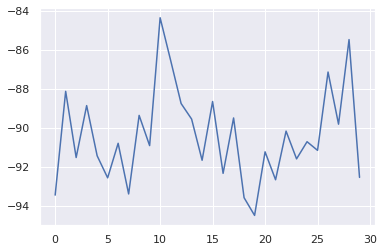

Episode: 3038, total numsteps: 52642, episode steps: 19, reward: -78.69 
Episode: 3039, total numsteps: 52655, episode steps: 13, reward: -101.3 
Episode: 3040, total numsteps: 52671, episode steps: 16, reward: -69.5 
Episode: 3041, total numsteps: 52701, episode steps: 30, reward: -75.8 
Episode: 3042, total numsteps: 52725, episode steps: 24, reward: -67.41 
Episode: 3043, total numsteps: 52738, episode steps: 13, reward: -100.86 
Episode: 3044, total numsteps: 52758, episode steps: 20, reward: -89.84 
Episode: 3045, total numsteps: 52771, episode steps: 13, reward: -101.3 
Episode: 3046, total numsteps: 52789, episode steps: 18, reward: -101.8 
Episode: 3047, total numsteps: 52802, episode steps: 13, reward: -99.97 
Episode: 3048, total numsteps: 52815, episode steps: 13, reward: -100.97 
Episode: 3049, total numsteps: 52839, episode steps: 24, reward: -97.16 
Episode: 3050, total numsteps: 52852, episode steps: 13, reward: -100.95 
Episode: 3051, total numsteps: 52858, episode step

In [35]:
plt.plot(range(len(av_rewards)),av_rewards)

In [40]:
av_rewards

[-19.8196, -16.537799999999994]